# Data Preparation

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

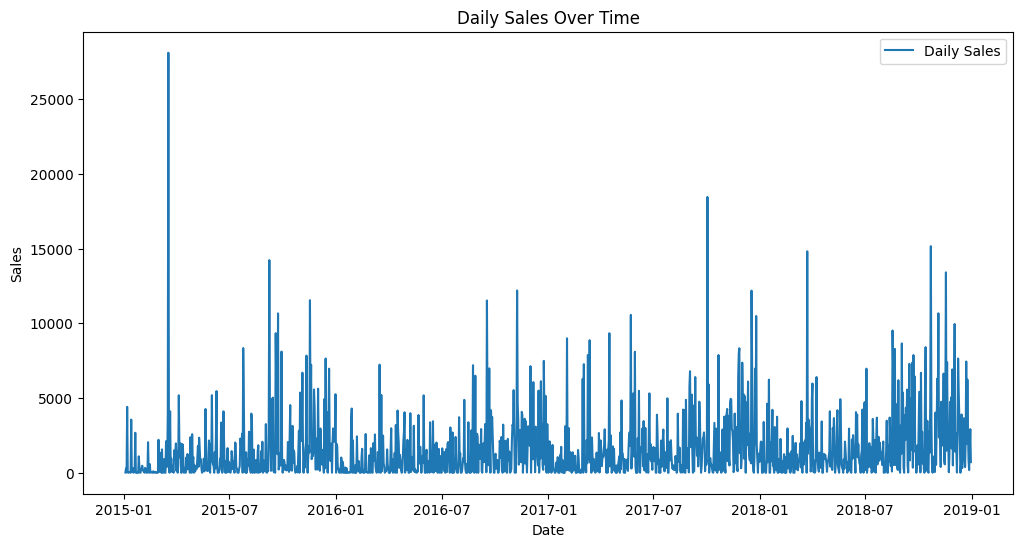

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('/kaggle/input/train-csv/train.csv')
print(df.head())
df.info()
from statsmodels.tsa.stattools import adfuller
sales = df[['Order Date', 'Sales']].copy()
sales['Order Date'] = pd.to_datetime(sales['Order Date'], dayfirst=True, format='mixed')
sales.set_index('Order Date', inplace=True)
daily_sales = sales.resample('D').sum()

daily_sales = daily_sales.fillna(0)

#Plot
plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales['Sales'], label="Daily Sales")
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


# Check for Stationarity

In [4]:
#ADF Test for Stationarity
result = adfuller(daily_sales['Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    daily_sales_diff = daily_sales.diff().dropna()
else:
    print("Series is stationary. No differencing needed.")


ADF Statistic: -4.92658337519625
p-value: 3.094891245873427e-05
Series is stationary. No differencing needed.


#  Model Training (SARIMA) And Forecasting

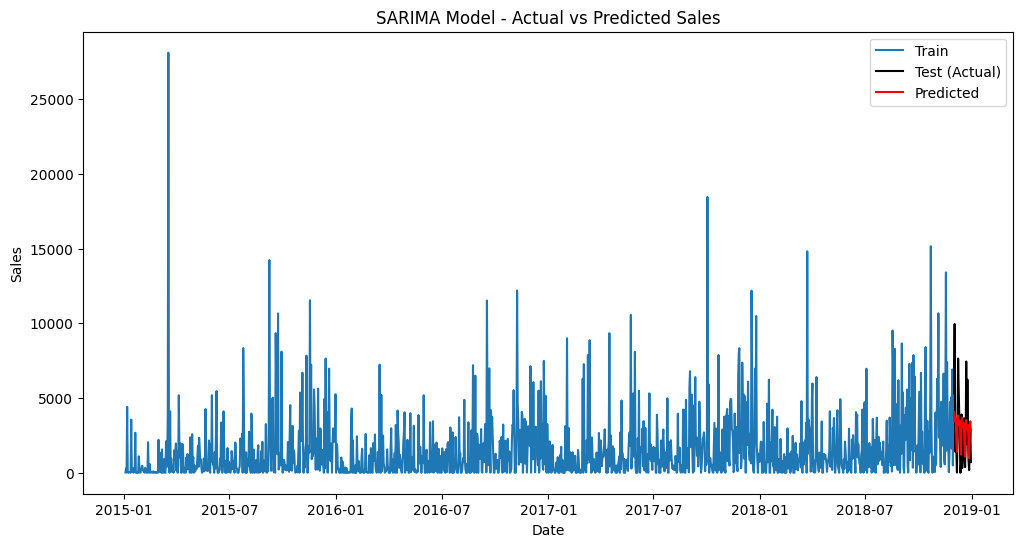

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

#Train-test split
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

#Define SARIMA model
# Order = (p, d, q), Seasonal order = (P, D, Q, s)
#Start with a simple configuration
model = SARIMAX(train['Sales'], 
                order=(1,0,1), 
                seasonal_order=(1,1,1,7), 
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_model = model.fit(disp=False)

pred = sarima_model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
                                
predicted_sales = pred.predicted_mean

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Sales'], label="Train")
plt.plot(test.index, test['Sales'], label="Test (Actual)", color='black')
plt.plot(predicted_sales.index, predicted_sales, label="Predicted", color='red')
plt.title("SARIMA Model - Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


###  Forecast Results
- The red line shows the **predicted sales** for the next 30 days.
- The shaded pink region shows the **confidence interval**, giving us a range of likely sales values.
- This forecast helps GlobalMart estimate how much inventory they need to stock.


# Visualization

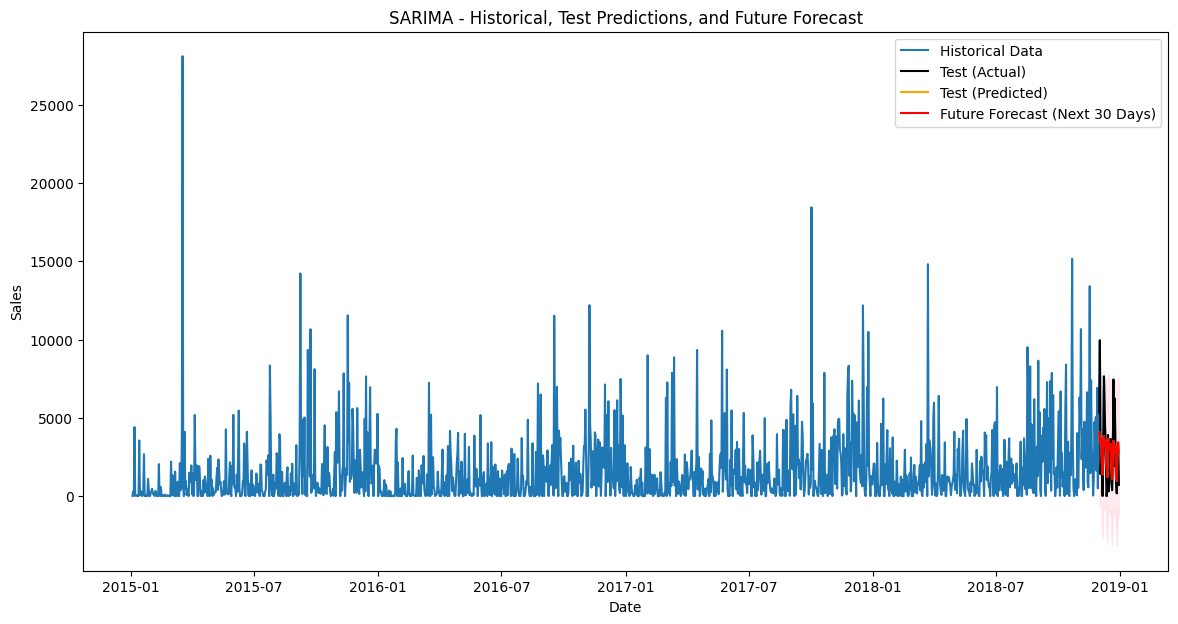

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
#Forecast next 30 days again for combined plot
future_forecast = sarima_model.get_forecast(steps=30)
forecast_values = future_forecast.predicted_mean
conf_int = future_forecast.conf_int()

#Plot everything together
plt.figure(figsize=(14,7))

#Historical data
plt.plot(daily_sales.index, daily_sales['Sales'], label="Historical Data")

#Predicted vs Actual (Test set)
plt.plot(test.index, test['Sales'], label="Test (Actual)", color='black')
plt.plot(predicted_sales.index, predicted_sales, label="Test (Predicted)", color='orange')

#Future forecast
plt.plot(forecast_values.index, forecast_values, label="Future Forecast (Next 30 Days)", color='red')

#Confidence interval shading
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:,0], 
                 conf_int.iloc[:,1], 
                 color='pink', alpha=0.3)

plt.title("SARIMA - Historical, Test Predictions, and Future Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


# Summary & Business Insights

### Key Findings
- The sales data was processed and resampled into daily totals.
- Stationarity check (ADF test) confirmed that the series is stationary (no differencing required).
- A SARIMA(1,0,1)(1,1,1,7) model was trained on historical data.
- The model performed reasonably well in predicting the last 30 days of sales.
- Using the trained model, we forecasted **sales for the next 30 days**.

### Business Insights for GlobalMart
1. **Inventory Planning**  
   The forecast provides a clear estimate of future daily sales. GlobalMart can use this to plan **how much inventory to stock** and avoid both overstocking and stockouts.

2. **Seasonality Consideration**  
   Weekly seasonality (captured by the SARIMA model) indicates that sales patterns repeat every 7 days. This suggests predictable spikes or dips in sales that should be considered for **supply chain planning**.

3. **Risk Management**  
   The confidence intervals around the forecast show the range of possible sales. Managers should prepare for the **upper bound** (to meet demand surges) and the **lower bound** (to minimize excess stock).

4. **Actionable Strategy**  
   - Ensure sufficient stock for high-demand days (predicted peaks).  
   - Optimize promotions or marketing during low-sales days.  
   - Use forecasts to align **procurement, logistics, and staffing** decisions.  

### Conclusion
The SARIMA model provides GlobalMart with a reliable short-term sales forecast. By leveraging this forecast, the company can make **data-driven inventory decisions**, reduce costs, and improve customer satisfaction.
